# Exercise 6

## 1) Neural Network Classifier from Scratch (10p.)

In this exercise we will implement a small neural network from scratch, i.e., only using numpy. This is nothing you would do "in real life" but it is a good exercise to deepen understanding. 

The network will consist of an arbitrary number of hidden layers with ReLU activation, a sigmoid output layer (as we are doing binary classification) and we will train it using the binary cross entropy (negative bernoulli likelihood). Ok, so lets start by importing and loading what we need. 

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Load our two moons (I promise we will get a new dataset in the next exercise)
train_data = dict(np.load("two_moons.npz", allow_pickle=True)) 
test_data = dict(np.load("two_moons_test.npz", allow_pickle=True))
# we need to reshape our labels so that they are [N, 1] and not [N] anymore
train_samples, train_labels = train_data["samples"], train_data["labels"][:, None]
test_samples, test_labels = test_data["samples"], test_data["labels"][:, None]


### 1.1.) Auxillary Functions (3 p.)
We start with implementing some auxillary functions we are going to need later. The sigmoid and relu activation functions, the binary cross entropy loss as well as their derviatives. 

The binary cross entropy loss is given as 
$-\dfrac{1}{N} \sum_{i=1}^N (y_i \log (p_i) + (1 - y_i) \log (1 - p_i))$ where $y_i$ denotes the ground truth label and $p_i$ the network prediction for sample $i$.

**Hint** all derivatives where derived/implemented during the lecture or previous exercise - so feel free to borrow them from there. 

In [62]:
def relu(x: np.ndarray) -> np.ndarray:
    """
    elementwise relu activation function
    :param x: input to function [shape: arbitrary]
    :return : relu(x) [shape: same as x]
    """
    return np.maximum(x,0)


def d_relu(x: np.ndarray) -> np.ndarray:
    """
    elementwise gradient of relu activation function
    :param x: input to function [shape: arbitrary]
    :return : d relu(x) / dx [shape: same as x]
    """
    return np.greater(x,0.0).astype(int)


def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    elementwise sigmoid activation function
    :param x: input to function [shape: arbitrary]
    :return : d sigmoid(x) /dx [shape: same as x]
    """
    return 1.0 / (1.0 + np.exp(-x))


def d_sigmoid(x: np.ndarray) -> np.ndarray:
    """
    elementwise sigmoid activation function
    :param x: input to function [shape: arbitrary]
    :return : sigmoid(x) [shape: same as x]
    """
    sigma = sigmoid(x)
    return sigma * (1.0 - sigma)


def binary_cross_entropy(predictions: np.ndarray, labels: np.ndarray) -> float:
    """
    binary cross entropy loss (negative bernoulli ll)
    :param predictions: predictions by model (shape [N])
    :param labels: class labels corresponding to train samples, (shape: [N])
    :return binary cross entropy
    """

    loss = labels*np.log(predictions)+(1-labels)*np.log(1-predictions)
    return - np.mean(loss)


def d_binary_cross_entropy(predictions: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    gradient of the binary cross entropy loss
    :param predictions: predictions by model (shape [N])
    :param labels: class labels corresponding to train samples, (shape [N])
    :return gradient of binary cross entropy, w.r.t. the predictions (shape [N])
    """
    N = predictions.shape[0]
    d_loss = -(labels/predictions)+((1-labels)/(1-predictions))
    return d_loss / N

## General Setup & Intialization

Next we are going to set up the Neural Network. We will represent it as a list of weight matrices and a list of bias vectors. Each list has one entry for each layer.


In [63]:
def init_weights(neurons_per_hidden_layer: List[int], input_dim: int, output_dim: int, seed: int = 0) \
        -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    :param neurons_per_hidden_layer: list of numbers, indicating the number of neurons of each hidden layer
    :param input_dim: input dimension of the network
    :param output_dim: output dimension of the network
    :param seed: seed for random number generator
    :return list of weights and biases as specified by dimensions and hidden layer specification
    """
    # seed random number generator
    rng = np.random.RandomState(seed)
    scale_factor = 1.0
    prev_n = input_dim
    weights = []
    biases = []

    # hidden layers
    for n in neurons_per_hidden_layer:
        # initialize weights with gaussian noise
        weights.append(scale_factor * rng.normal(size=[prev_n, n]))
        # initialize bias with zeros
        biases.append(np.zeros([1, n]))
        prev_n = n

    # output layer
    weights.append(scale_factor * rng.normal(size=[prev_n, output_dim]))
    biases.append(np.zeros([1, output_dim]))

    return weights, biases

**NOTE** As NNs are non-convex, initialization plays a very important role in NN training and there is a lot of work into how to initialize them properly - this here is not a very good initialization, but sufficient for our small example.

## 1.2) Forward Pass (3 p.)

Next step is the forward pass, i.e., propagate a batch of samples through the network to get the final prediciton.
But that's not all - to compute the gradietns later we also need to store all necessary quantities, here those are:
- The input to every layer (here called h's)
- The "pre-activation" of every layer, i.e., the qantity that is fed into the non-linearity (here called z's)


In [64]:
def forward_pass(x: np.ndarray, weights: List[np.ndarray], biases: List[np.ndarray])\
        -> Tuple[np.ndarray, List[np.ndarray], List[np.ndarray]]:
    """
    propagate input through network
    :param x: input: (shape, [N x input_dim])
    :param weights: weight parameters of the layers
    :param biases: bias parameters of the layers
    :return: - Predictions of the network (shape, [N x out_put_dim])
             - hs: output of each layer (input + all hidden layers) (length: len(weights))
             - zs: preactivation of each layer (all hidden layers + output) (length: len(weights))
    """

    hs = []  # list to store all inputs
    zs = []  # list to store all pre-activations
    
    # input to first hidden layer is just the input to the network 
    h = x
    hs.append(h)
    
    ### TODO #########################
    # pass "h" to all hidden layers
    # record all inputs and pre-activations in the lists
    ##################################
    
    l = len(weights)-1
    
    for i in range(l):
        z = h@weights[i] + biases[i]
        zs.append(z)
        h = relu(z)
        hs.append(h)
    
    z = h@weights[l] + biases[l]
    zs.append(z)
    
    # record all inputs and pre-activations in the lists
    ##################################
    y = sigmoid(z)   # z denotes the pre-activation of the output layer here. Feel free to rename it

    return y, hs, zs




## 1.3) Backward Pass (4 p.)

For training by gradient descent we need - well - gradients. Those are computed using backpropagation during the so called "backward pass". We will use the chain rule to propagate the gradient back through the network and at every layer, compute the gradients for the weights and biases at that layer. The initial gradient is given by the gradient of the loss function w.r.t. the network output. 

In [65]:
def backward_pass(loss_grad: np.ndarray, 
                  hs: List[np.ndarray], zs: List[np.ndarray], 
                  weights: List[np.ndarray], biases: List[np.ndarray]) -> \
    Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    propagate gradient backwards through network
    :param loss_grad: gradient of the loss function w.r.t. the network output (shape: [N, 1])
    :param hs: values of all hidden layers during forward pass
    :param zs: values of all preactivations during forward pass
    :param weights: weight paramameters of the layers
    :param biases: bias parameters of the layers
    :return: d_weights: List of weight gradients - one entry with same shape for each entry of "weights"
             d_biases: List of bias gradients - one entry with same shape for each entry of "biases"
    """

    # return gradients as lists - we pre-initialize the lists as we iterate backwards
    d_weights = [None] * len(weights)
    d_biases = [None] * len(biases)

    ### TODO #########################
    l = len(weights)-1
    
    dz = (loss_grad*d_sigmoid(zs[l]))
    d_weights[l] = hs[l].T @ dz
    d_biases[l] =  np.ones([1,hs[l].shape[0]]) @ dz
    
    for i in reversed(range(l)):
        dz = (dz @ weights[i+1].T) * d_relu(zs[i])
        d_weights[i] = hs[i].T @ dz
        d_biases[i] = np.ones([1,hs[i].shape[0]]) @ dz
    ##################################

    return d_weights, d_biases

## Tying Everything Together 

Finally we can tie everything together and train our network. 

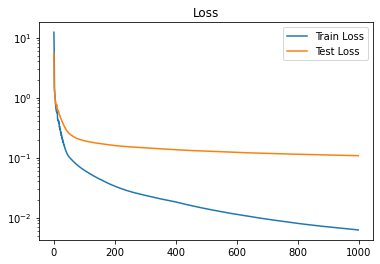

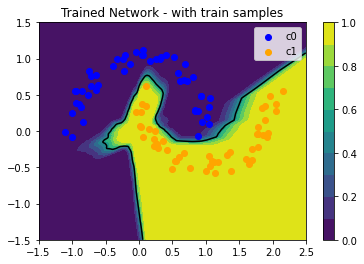

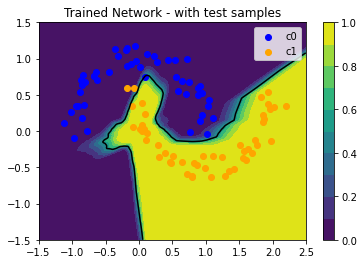

In [66]:
# hyper parameters 
layers = [64, 64]
learning_rate = 1e-2

# init model
weights, biases = init_weights(layers, input_dim=2, output_dim=1, seed=42)


#book keeping
train_losses = []
test_losses = []

# Here we work with a simple gradient descent implementation, using the whole dataset at each iteration,
# You can modify it to stochastic gradient descent or a batch gradient descent procedure as an exercise
for i in range(1000):
    
    # predict network outputs and record intermediate quantities using the forward pass
    prediction, hs, zs = forward_pass(train_samples, weights, biases)
    train_losses.append(binary_cross_entropy(prediction, train_labels))

    # compute gradients
    loss_grad = d_binary_cross_entropy(prediction, train_labels)
    w_grads, b_grads = backward_pass(loss_grad, hs, zs, weights, biases)

    # apply gradients
    for i in range(len(w_grads)):
        weights[i] -= learning_rate * w_grads[i]
        biases[i] -= learning_rate * b_grads[i]

    test_losses.append(binary_cross_entropy(forward_pass(test_samples, weights, biases)[0], test_labels))

# plotting
plt.title("Loss")
plt.semilogy(train_losses)
plt.semilogy(test_losses)
plt.legend(["Train Loss", "Test Loss"])

def plt_solution(samples, labels):
    plt_range = np.arange(-1.5, 2.5, 0.01)
    plt_grid = np.stack(np.meshgrid(plt_range, plt_range), axis=-1)
    plt_grid_shape = plt_grid.shape[:2]
    pred_grid = np.reshape(forward_pass(plt_grid, weights, biases)[0], plt_grid_shape)
    plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[0.5], colors=["black"])
    plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)
    plt.colorbar()
    s0 = plt.scatter(x=samples[labels[:, 0] == 0, 0], y=samples[labels[:, 0] == 0, 1],
                     label="c=0", c="blue")
    s1 = plt.scatter(x=samples[labels[:, 0] == 1, 0], y=samples[labels[:, 0] == 1, 1],
                     label="c=1", c="orange")
    plt.legend([s0, s1], ["c0", "c1"])
    plt.xlim(-1.5, 2.5)
    plt.ylim(-1.5, 1.5)


plt.figure()
plt.title("Trained Network - with train samples")
plt_solution(train_samples, train_labels)

plt.figure()
plt.title("Trained Network - with test samples")
plt_solution(test_samples, test_labels)
plt.show()



## 2.) MNIST Classifier with PyTorch (10 p.)

Modern deep learning approaches are mostly implemented using special libraries, providing functionality such as automatic differentiation, common SGD Optimiziers, easy usage of GPUs and so on. We will use PyTorch, at the moment the, arguably, most common framework (for research).

## Getting Started
You can find a documentation of the PyTorch API here https://pytorch.org/docs/stable/torch.html# . Don't worry if it seems a lot, we will point out the relevant bits during the exercise as we go along 

**Installation** 
You can find installation instructions here https://pytorch.org/ . Take the most recent stable version (1.7.X). We won't use GPUs here so you can take the cuda-free installation. We also don't need torchvision nor torchaudio so those don't need to be installed.

**Data**
We finally use a new dataset. The classical MNIST Handwritten Digit Classification set. It consists of grayscale images of size 28x28 of handwritten digits. Let's load it and visualize some of the images. We also do some preprocessing. 


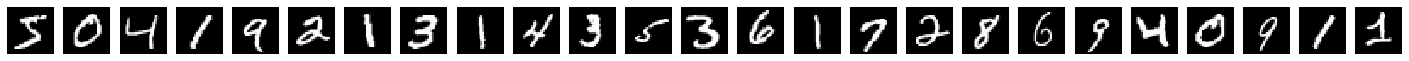

In [67]:
import torch

data_dict = dict(np.load("mnist.npz"))

# prepare data:
# - images are casted to float 32 (from uint8) mapped in interval (0,1) and a "fake" color channel is added.
#   torch uses "NCHW"-layout for 2d convolutions. (i.e., a batch of images is represented as a 4 d tensor 
#   where the first axis (N) is the batch dimension, the second the (color) **C**hannels, followed by a **H**eight
#   and a **W**idth axis). As we have grayscale images there is only 1 color channel.  
# - targets are mapped to one hot encoding - torch does that for us 
with torch.no_grad():
    train_samples = torch.from_numpy(data_dict["train_samples"].astype(np.float32) / 255.0).reshape(-1, 1, 28, 28)
    train_labels = torch.nn.functional.one_hot(torch.from_numpy(data_dict["train_labels"]))
    test_samples = torch.from_numpy(data_dict["test_samples"].astype(np.float32) / 255.0).reshape(-1, 1, 28, 28)
    test_labels = torch.nn.functional.one_hot(torch.from_numpy(data_dict["test_labels"]))


# plot first 25 images in train setp
plt.figure(figsize=(25, 1))
for i in range(25):
    plt.subplot(1, 25, i + 1)
    # drop channel axis for plotting
    plt.imshow(train_samples[i, 0], cmap="gray", interpolation="none")
    plt.gca().axis("off")
    

## 2.1) Specifiying Networks (4 p.)

The first step in training a neural network is specifying its architecture. Here we will actually build two networks
- classifier_fc: A classifier consisting only of fully connected layers
- classifier_conv: A classifier combining, convolutional layers, pooling and fully connected layers

In the torch API under torch.nn you can find everything you need. Take a look at the classes "Linear", "ReLU", "Softmax", "Conv2d", "MaxPool2d" and "Sequential"

In [68]:
layers_fc = [
    torch.nn.Flatten(), # Flatten image into vector
    ## TODO ##
    # Hidden Layer 1: 256 neurons, Relu activation
    torch.nn.Linear(784,256),
    torch.nn.ReLU(),
    # Hidden Layer 2: 128 neurons, Relu activation
    torch.nn.Linear(256,128),
    torch.nn.ReLU(),
    # Outputlayer: 10 neurons (one for each class), softmax activation
    torch.nn.Linear(128,10),
    torch.nn.Softmax(dim=1)
    ###########
]
classifier_fc = torch.nn.Sequential(*layers_fc)


layers_conv = [
    # Conv Layer 1: 8 filters of 3x3 size, ReLU, Max Pool with size 2x2 and stride 2
    torch.nn.Conv2d(1,8,[3,3]),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2),stride=2),
    # Conv Layer 2: 16 filters of 3x3 size, ReLU, Max Pool with size 2x2 and stride 2
    torch.nn.Conv2d(8,16,(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2),stride=2),
    # Flatten
    torch.nn.Flatten(),
    # Fully Connected Layer 1: 64 Neurons, ReLU
    torch.nn.Linear(400,64),
    torch.nn.ReLU(),
    # Outputlayer: 10 neurons (one for each class), softmax activation
    torch.nn.Linear(64,10),
    torch.nn.Softmax(dim=1)
]
classifier_conv = torch.nn.Sequential(*layers_conv) 

From now on we going to use both the classifiers interchangable, pick one here and the rest should work with both models

In [69]:
classifier = classifier_fc 
#classifier = classifier_conv 

## 2.2) Optimizer and Loss (2 p.)

Next we need to specify an optimizer and a loss function. For the optimizer we will use Adam (look at torch.optim) with default parameters and as a loss function we will use the cross-entropy 

In [70]:
optimizer = torch.optim.Adam(classifier.parameters())

def cross_entropy_loss(labels: torch.Tensor, predictions: torch.Tensor) -> torch.Tensor:
    """ Cross entropy Loss:
    :param labels: Ground truth class labels (shape; [N, num_classes])
    :param predictions: predicted class labels (shape: [N, num_classes])
    :return: cross entropy (scalar)
    """
    loss = labels * torch.log(torch.clamp(predictions,1e-10,1.0))
    return -torch.mean(torch.sum(loss,dim=-1))    

## 2.3) Data Loader (2 p.) 

For batch gradient descent we need to shuffle and batch the data, PyTorch provdies some functionality for that in form of the "DataLoader" (Look at torch.utils.data). In the simplest form used here, it simply shuffles and batches the data but you can also build more complex preprocessing pipelines. We also need a loader for the test data.

In [71]:
batch_size = 64

train_dataset = torch.utils.data.TensorDataset(train_samples,train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True)
test_dataset = torch.utils.data.TensorDataset(test_samples,test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size,shuffle=True)

## 2.4) Training (2 p.)

We now have all ingredients and can implement our train loop and a evaluation procedure. You should get a test set accuracy of > 0.95 with both architectures in 2 epochs.

Epoch 001
Epoch 002
Test Set Accuracy: 0.975, Test Loss 0.083


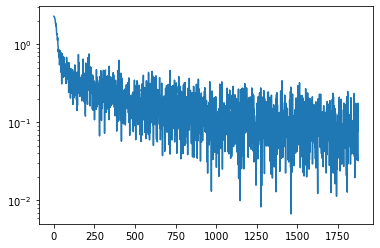

In [72]:
epochs = 2  # small number of epochs should be sufficient to get descent performance

train_losses = []
test_losses = []

for i in range(epochs):
    print("Epoch {:03d}".format(i + 1))
    for batch in train_loader:
        # forward pass        #
        samples, labels = batch
        # free gradient buffer
        optimizer.zero_grad()
        # forward pass        #
        predictions = classifier(samples)
        # backward pass       #
        loss = cross_entropy_loss(labels,predictions)
        loss.backward()
        # update step         #
        optimizer.step()
        #######################
        train_losses.append(loss.detach().numpy())

# Evaluate (we still need batching as evaluating all test points at once would probably melt your Memory)
avg_loss = avg_acc = 0
for batch in test_loader:
    samples, labels = batch
    predictions = classifier(samples)
    loss = cross_entropy_loss(labels, predictions)
    acc = torch.count_nonzero(predictions.argmax(dim=-1) == labels.argmax(dim=-1)) / samples.shape[0]

    avg_acc += acc / len(test_loader)
    avg_loss += loss / len(test_loader)


print("Test Set Accuracy: {:.3f}, Test Loss {:.3f}".format(avg_acc.detach().numpy(), avg_loss.detach().numpy()))

plt.figure()
plt.semilogy(train_losses)
plt.show()